In [1]:
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import cartopy.crs as ccrs 
import cartopy.feature as cfeature
import xarray as xr
from scipy.spatial import cKDTree
import glob
import argparse
from datetime import datetime
from mpl_toolkits.basemap import Basemap
import scipy.stats as stats

In [2]:
# base_path = "/gpfs/work3/0/ai4nbs/hurry_wave/north_sea"



In [3]:
year = 2023
model_name = str(year)  # Use the year as the model name
data_name = str(year)  # Use the year as the data name

area = [65, -12, 48, 10] # DCSM area in the North Sea (degrees): North, West, South, East

# model_path = os.path.join(base_path, '04_modelruns',"YearSims",model_name)
model_path = '/gpfs/work3/0/ai4nbs/hurry_wave/north_sea/04_modelruns/SENSITIVITY/07July2023/0002'

output_dir = os.path.join(model_path, '1_postprocessing_MAP')
if not os.path.exists(output_dir):
    os.makedirs(output_dir, exist_ok=True)

ERA5_data_path = '/gpfs/work3/0/ai4nbs/ERA5_data'

# Buoy data path
buoy_data_path = os.path.join('/gpfs/work3/0/ai4nbs/hurry_wave/north_sea/01_data/Waterinfo_RWS', data_name)  # CHANGE THIS!!

inp_file = os.path.join(model_path, 'hurrywave.inp')
tstart = None
tstop = None

# DCSM bounding box: [North, West, South, East]
area = [65, -12, 48, 10]  # (N, W, S, E)

# Find the start and stop times from the input file
with open(inp_file, 'r') as f:
    for line in f:
        if line.strip().startswith('tstart'):
            tstart = line.split('=')[1].strip()
        if line.strip().startswith('tstop'):
            tstop = line.split('=')[1].strip()
        if line.strip().startswith('tspinup'):
            tspinup = line.split('=')[1].strip()


# Ensure time is in "yyyymmdd hhmmss" format
def parse_time(s):
    parts = s.strip().split()
    if len(parts) == 2:
        date, time = parts
    elif len(parts) == 1:
        date = parts[0][:8]
        time = parts[0][8:] if len(parts[0]) > 8 else "000000"
    else:
        date, time = "00000000", "000000"  # fallback
    return f"{date} {time}"

tstart_str = parse_time(tstart)
tstop_str = parse_time(tstop)

tstart_dt = datetime.strptime(tstart_str, "%Y%m%d %H%M%S")
tstop_dt = datetime.strptime(tstop_str, "%Y%m%d %H%M%S")

# Paths to individual NetCDF files (each with a different variable)
ERA5_netcdf_files = {
    'swh': os.path.join(ERA5_data_path,'significant_height_of_combined_wind_waves_and_swell', f'global_significant_height_of_combined_wind_waves_and_swell_{year}.nc'),
    'pp1d': os.path.join(ERA5_data_path, 'peak_wave_period', f'global_peak_wave_period_{year}.nc'),
    # Add more as needed
}

pinball_quantiles = [0.05,0.1, 0.25, 0.5, 0.75, 0.9,0.95]


def read_station_names_from_obs(file_path):
    names = []
    with open(file_path, 'r') as f:
        for line in f:
            if '#' in line:
                name = line.split('# ')[1].strip()
                names.append(name)
    return names

obs_file_path = os.path.join(model_path, 'hurrywave.obs')
station_names = read_station_names_from_obs(obs_file_path)

### Post-process Hurrywave results
# Get the results from the netcdf file

map_file = os.path.join(model_path,'hurrywave_map.nc')
his_file = os.path.join(model_path,'hurrywave_his.nc')



In [4]:
xr_nc = xr.open_dataset(map_file , decode_times=True)

modig = {"msk": xr_nc["msk"],
         "zb": xr_nc["zb"],
         "Hm0": xr_nc["hm0"],
         #"Hm0_max": xr_nc["hm0max"],
         "Tp": xr_nc["tp"],
         "DIR": xr_nc["wavdir"],
         "ds": xr_nc["dirspr"],
         "windspeed": xr_nc["windspeed"]
        }

# Assuming "time" is available in modig dictionary
time_variable =  xr_nc["time"]

# Remove spinup period from all data (tspinup is in seconds)
if tspinup is not None:
    tspinup_seconds = int(float(tspinup))
    spinup_end_time = tstart_dt + pd.Timedelta(seconds=tspinup_seconds)
    # Find indices after spinup for model
    time_values = pd.to_datetime(time_variable.values)
    valid_indices = np.where(time_values >= spinup_end_time)[0]
    # Filter modig variables
    for key in modig:
        if "time" in modig[key].dims:
            modig[key] = modig[key].isel(time=valid_indices)
    # Also filter time_variable
    time_variable = time_variable.isel(time=valid_indices)

xr_nc.close()

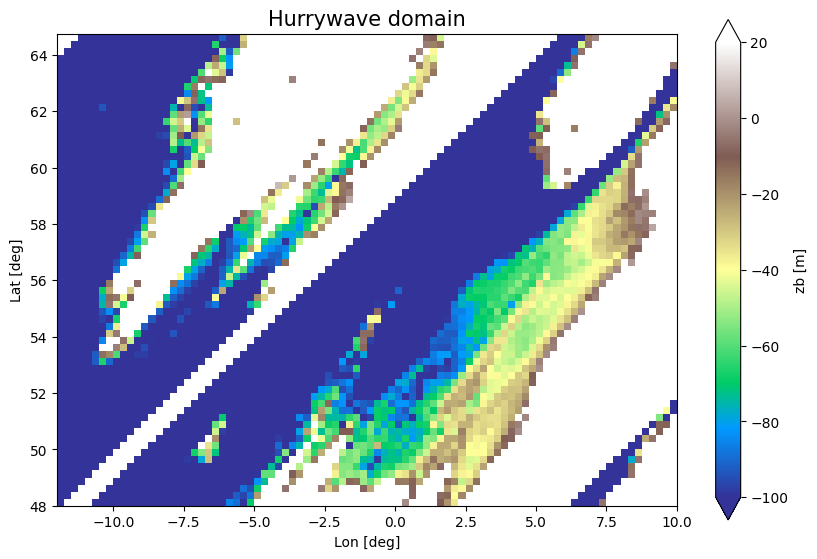

In [5]:
# plot bed level - Hurrywave
fig, ax = plt.subplots(figsize=(10, 6.5), ncols=1, nrows=1, sharex=True, sharey=True)

im = modig['zb'].plot(ax =ax,
                 x="x",
                 y="y",
                 cmap = "terrain",
                 vmin = -100, vmax = 20,
                 cbar_kwargs={'label': 'zb [m]'})

# plt.scatter(his.station_x, his.station_y, color='k')
# for x, y, id in zip(his.station_x.values, his.station_y.values, his.station_id.values):
#     plt.text(x, y, ' ' + '{:.0f}'.format(id), color='k', fontsize=15)

ax.set_aspect('equal', adjustable='box')
ax.set_title('Hurrywave domain', fontsize = 15)

# ax.set_xticklabels([x for x in ax.get_xticks()])  # divide every tick value by 1000
# ax.set_yticklabels([y/1e3 for y in ax.get_yticks()])  # divide every tick value by 1000
ax.set_xlabel('Lon [deg]')
ax.set_ylabel('Lat [deg]')

output_path = os.path.join(output_dir, 'bathy3.png')
plt.show()
fig.savefig(output_path, dpi=300, bbox_inches='tight')



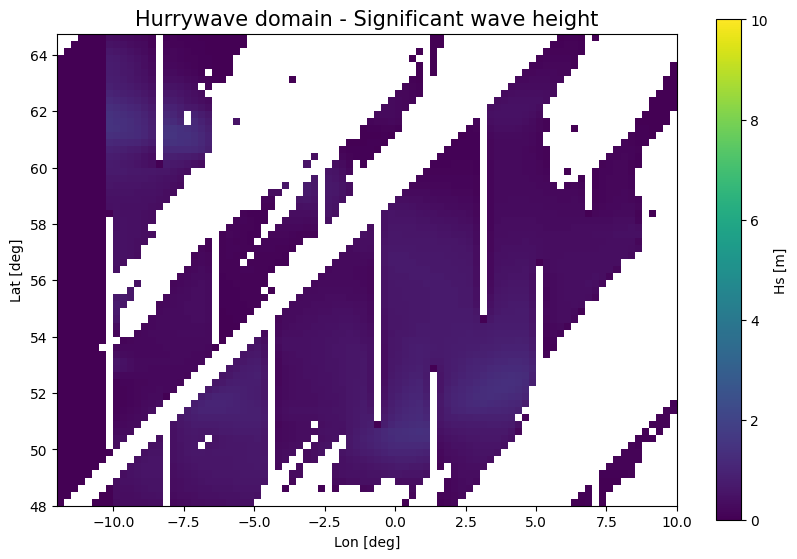

In [6]:
# plot wave height - Hurrywave
fig, ax = plt.subplots(figsize=(10, 6.5), ncols=1, nrows=1, sharex=True, sharey=True)

im = modig['Hm0'].isel(time=-97).plot(ax =ax,
                 x="x",
                 y="y",
                 cmap = "viridis",
                 vmin = 0, vmax = 10,
                 cbar_kwargs={'label': 'Hs [m]'})

# plt.scatter(his.station_x, his.station_y, color='k')
# for x, y, id in zip(his.station_x.values, his.station_y.values, his.station_id.values):
#     plt.text(x, y, ' ' + '{:.0f}'.format(id), color='k', fontsize=15)

ax.set_aspect('equal', adjustable='box')
ax.set_title('Hurrywave domain - Significant wave height', fontsize = 15)

# ax.set_xticklabels([x for x in ax.get_xticks()])  # divide every tick value by 1000
# ax.set_yticklabels([y/1e3 for y in ax.get_yticks()])  # divide every tick value by 1000
ax.set_xlabel('Lon [deg]')
ax.set_ylabel('Lat [deg]') 

#plt.scatter(bnd[:, 0], bnd[:, 1], color='red')
#xr_nc["zs"][1].ugrid.plot(ax=ax, cmap='gray')

output_path = os.path.join(output_dir, 'waveheight3.png')
plt.show()
fig.savefig(output_path, dpi=300, bbox_inches='tight')

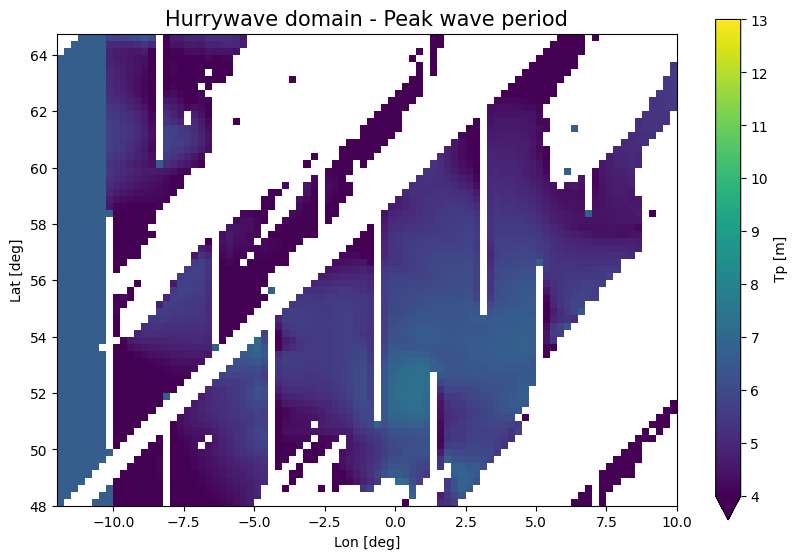

In [7]:


# plot wave period - Hurrywave
fig, ax = plt.subplots(figsize=(10, 6.5), ncols=1, nrows=1, sharex=True, sharey=True)

im = modig['Tp'].isel(time=-97).plot(ax =ax,
                 x="x",
                 y="y",
                 cmap = "viridis",
                 vmin = 4, vmax = 13,
                 cbar_kwargs={'label': 'Tp [m]'})

# plt.scatter(his.station_x, his.station_y, color='k')
# for x, y, id in zip(his.station_x.values, his.station_y.values, his.station_id.values):
#     plt.text(x, y, ' ' + '{:.0f}'.format(id), color='k', fontsize=15)

ax.set_aspect('equal', adjustable='box')
ax.set_title('Hurrywave domain - Peak wave period', fontsize = 15)

# ax.set_xticklabels([x for x in ax.get_xticks()])  # divide every tick value by 1000
# ax.set_yticklabels([y/1e3 for y in ax.get_yticks()])  # divide every tick value by 1000
ax.set_xlabel('Lon [deg]')
ax.set_ylabel('Lat [deg]')

# plt.scatter(bnd[:, 0], bnd[:, 1], color='red')
#xr_nc["zs"][1].ugrid.plot(ax=ax, cmap='gray')

output_path = os.path.join(output_dir, 'waveperiod3.png')
plt.show()
fig.savefig(output_path, dpi=300, bbox_inches='tight')




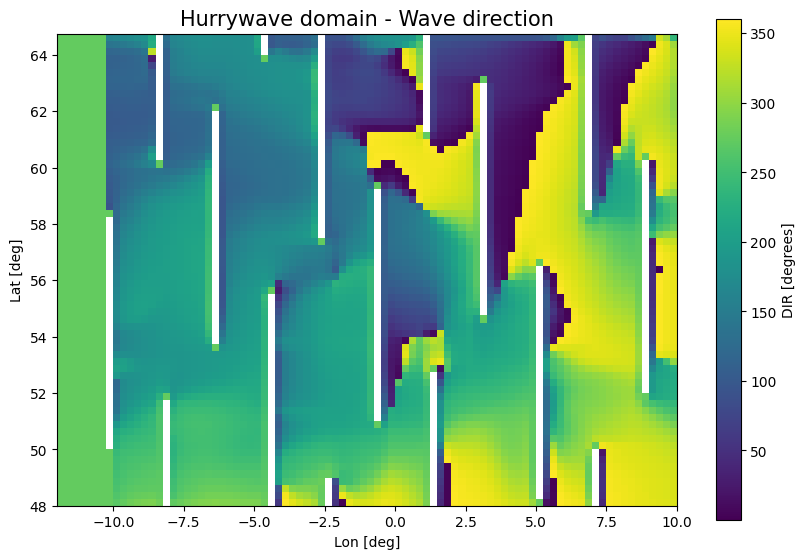

In [8]:
# plot wave direction - Hurrywave
fig, ax = plt.subplots(figsize=(10, 6.5), ncols=1, nrows=1, sharex=True, sharey=True)

im = modig['DIR'].isel(time=-97).plot(ax =ax,
                 x="x",
                 y="y",
                 cmap = "viridis",
                 cbar_kwargs={'label': 'DIR [degrees]'})

# plt.scatter(his.station_x, his.station_y, color='k')
# for x, y, id in zip(his.station_x.values, his.station_y.values, his.station_id.values):
#     plt.text(x, y, ' ' + '{:.0f}'.format(id), color='k', fontsize=15)

ax.set_aspect('equal', adjustable='box')
ax.set_title('Hurrywave domain - Wave direction', fontsize = 15)

# ax.set_xticklabels([x for x in ax.get_xticks()])  # divide every tick value by 1000
# ax.set_yticklabels([y/1e3 for y in ax.get_yticks()])  # divide every tick value by 1000
ax.set_xlabel('Lon [deg]')
ax.set_ylabel('Lat [deg]')

# plt.scatter(bnd[:, 0], bnd[:, 1], color='red')
#xr_nc["zs"][1].ugrid.plot(ax=ax, cmap='gray')

output_path = os.path.join(output_dir, 'direction3.png')
plt.show()
fig.savefig(output_path, dpi=300, bbox_inches='tight')

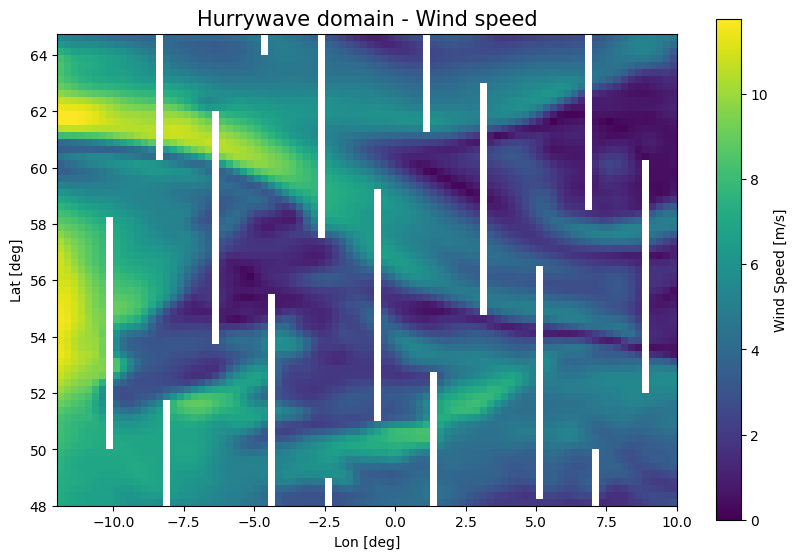

In [9]:
# plot wind speed direction - Hurrywave
fig, ax = plt.subplots(figsize=(10, 6.5), ncols=1, nrows=1, sharex=True, sharey=True)

im = modig['windspeed'].isel(time=-97).plot(ax =ax,
                 x="x",
                 y="y",
                 cmap = "viridis",
                 cbar_kwargs={'label': 'Wind Speed [m/s]'})

# plt.scatter(his.station_x, his.station_y, color='k')
# for x, y, id in zip(his.station_x.values, his.station_y.values, his.station_id.values):
#     plt.text(x, y, ' ' + '{:.0f}'.format(id), color='k', fontsize=15)

ax.set_aspect('equal', adjustable='box')
ax.set_title('Hurrywave domain - Wind speed', fontsize = 15)

# ax.set_xticklabels([x for x in ax.get_xticks()])  # divide every tick value by 1000
# ax.set_yticklabels([y/1e3 for y in ax.get_yticks()])  # divide every tick value by 1000
ax.set_xlabel('Lon [deg]')
ax.set_ylabel('Lat [deg]')

# plt.scatter(bnd[:, 0], bnd[:, 1], color='red')
#xr_nc["zs"][1].ugrid.plot(ax=ax, cmap='gray')

output_path = os.path.join(output_dir, 'windspeed3.png')
plt.show()
fig.savefig(output_path, dpi=300, bbox_inches='tight')